# Titanic Survival Prediction - Feature Engineering
# =================================================

# ## 📋 Objective
# Create new features to improve the predictive power of our models:
# - Extract information from existing variables
# - Create interaction variables
# - Transform categorical variables
# - Scale numerical variables
# - Prepare data for modeling

## 1. Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder
import re
import warnings

# Helper functions
import sys
import os
sys.path.append('../src')
from utils.helpers import save_current_plot

In [2]:
# Configuration
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Loading Cleaned Data

In [3]:
# Load cleaned dataset from previous step
df = pd.read_csv("../data/processed/train_processed.csv")

print("🚢 CLEAN DATASET LOADED")
print("=" * 30)
print(f"📊 Dimensions: {df.shape}")
print(f"👥 Total records: {len(df)}")

print("\n📋 Dataset information:")
print(df.info())

print("\n🔍 First rows:")
print(df.head())

# Verify there are no missing values
missing_check = df.isnull().sum()
print(f"\n❌ Missing values check:")
print(missing_check[missing_check > 0])

if missing_check.sum() == 0:
    print("✅ Confirmed: No missing values")

🚢 CLEAN DATASET LOADED
📊 Dimensions: (891, 9)
👥 Total records: 891

📋 Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    object 
 8   Cabin_Known  891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB
None

🔍 First rows:
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Cabin_Known
0         0       3    male  22.0      1      0   7.2500        S            0
1         1       1  female  38.0      1      0  71.2833        C            1
2         1       3  fe

## 3. Feature Engineering: Derived Variables

In [4]:
print("\n🔧 CREATING NEW FEATURES")
print("=" * 40)

# Create copy for feature engineering
df_features = df.copy()


🔧 CREATING NEW FEATURES


### 3.1 Family Size


👨‍👩‍👧‍👦 FEATURE 1: FAMILY SIZE
FamilySize distribution:
FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

Survival by family size:
            Total  Survivors  Survival_Rate
FamilySize                                 
1             537        163          0.304
2             161         89          0.553
3             102         59          0.578
4              29         21          0.724
5              15          3          0.200
6              22          3          0.136
7              12          4          0.333
8               6          0          0.000
11              7          0          0.000
✅ Graph saved: ../results/figures/feature_engineering/family_size_analysis.png


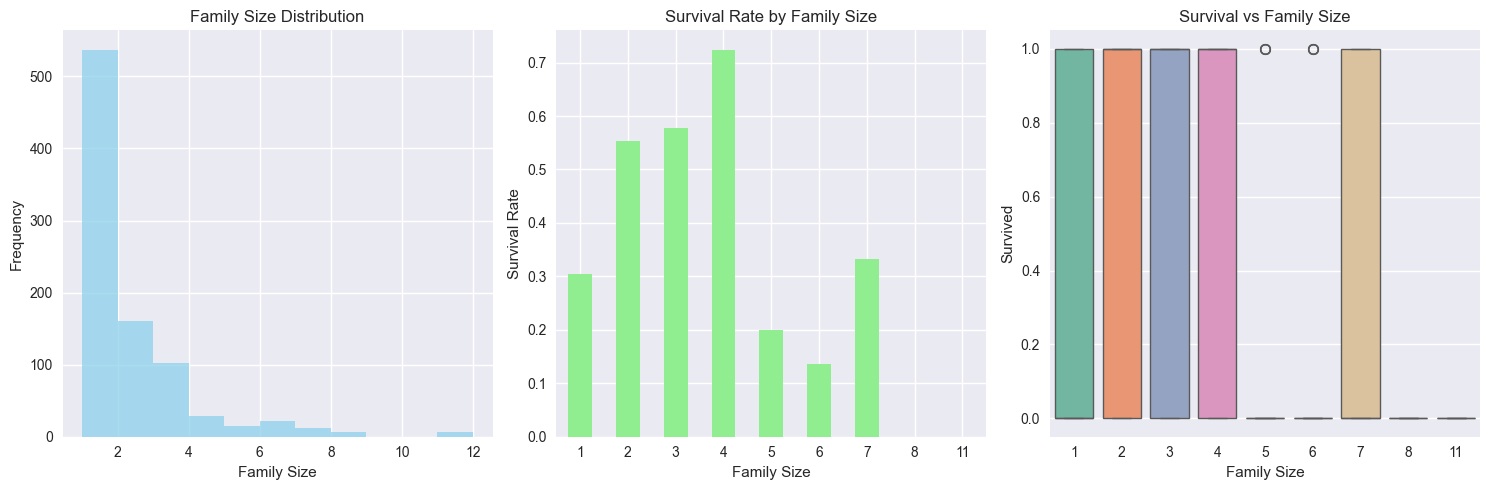

In [5]:
print("\n👨‍👩‍👧‍👦 FEATURE 1: FAMILY SIZE")
print("=" * 25)

# FamilySize = SibSp + Parch + 1 (the passenger themselves)
df_features["FamilySize"] = df_features["SibSp"] + df_features["Parch"] + 1

print("FamilySize distribution:")
family_size_dist = df_features["FamilySize"].value_counts().sort_index()
print(family_size_dist)

# Analyze survival by family size
family_survival = (
    df_features.groupby("FamilySize")["Survived"].agg(["count", "sum", "mean"]).round(3)
)
family_survival.columns = ["Total", "Survivors", "Survival_Rate"]
print("\nSurvival by family size:")
print(family_survival)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_features["FamilySize"].hist(
    bins=range(1, df_features["FamilySize"].max() + 2), alpha=0.7, color="skyblue"
)
plt.title("Family Size Distribution")
plt.xlabel("Family Size")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
family_survival["Survival_Rate"].plot(kind="bar", color="lightgreen")
plt.title("Survival Rate by Family Size")
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
sns.boxplot(data=df_features, x="FamilySize", y="Survived", palette="Set2")
plt.title("Survival vs Family Size")
plt.xlabel("Family Size")

plt.tight_layout()
save_current_plot("family_size_analysis", "../results/figures/feature_engineering/")
plt.show()

### 3.2 Is Alone (Traveling Alone)


🚶 FEATURE 2: IS ALONE
Survival by traveling alone:
Survived    0    1  All
IsAlone                
0         175  179  354
1         374  163  537
All       549  342  891

Percentages:
Survived     0     1
IsAlone             
0         49.4  50.6
1         69.6  30.4
✅ Graph saved: ../results/figures/feature_engineering/is_alone_analysis.png


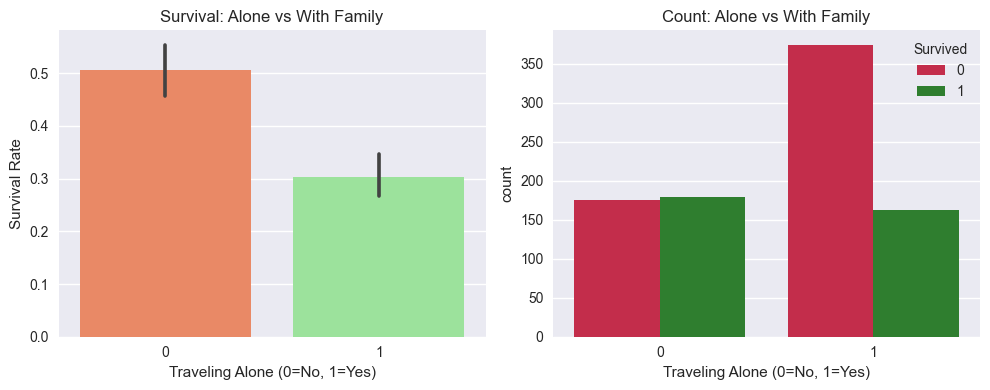

In [6]:
print("\n🚶 FEATURE 2: IS ALONE")
print("=" * 20)

# IsAlone = 1 if FamilySize == 1, 0 otherwise
df_features["IsAlone"] = (df_features["FamilySize"] == 1).astype(int)

# Analysis
alone_analysis = pd.crosstab(
    df_features["IsAlone"], df_features["Survived"], margins=True
)
print("Survival by traveling alone:")
print(alone_analysis)

alone_survival_pct = (
    pd.crosstab(df_features["IsAlone"], df_features["Survived"], normalize="index")
    * 100
)
print("\nPercentages:")
print(alone_survival_pct.round(1))

# Visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.barplot(
    data=df_features, x="IsAlone", y="Survived", palette=["coral", "lightgreen"]
)
plt.title("Survival: Alone vs With Family")
plt.xlabel("Traveling Alone (0=No, 1=Yes)")
plt.ylabel("Survival Rate")

plt.subplot(1, 2, 2)
sns.countplot(
    data=df_features, x="IsAlone", hue="Survived", palette=["crimson", "forestgreen"]
)
plt.title("Count: Alone vs With Family")
plt.xlabel("Traveling Alone (0=No, 1=Yes)")

plt.tight_layout()
save_current_plot("is_alone_analysis", "../results/figures/feature_engineering/")
plt.show()

### 3.3 Age Groups


👶👨👴 FEATURE 3: AGE GROUPS
Survival by age group:
             Total  Survivors  Survival_Rate
AgeGroup                                    
Child           68         39          0.574
Middle_Age     239        101          0.423
Senior          26          7          0.269
Teen            45         22          0.489
Young_Adult    513        173          0.337
✅ Graph saved: ../results/figures/feature_engineering/age_groups_analysis.png


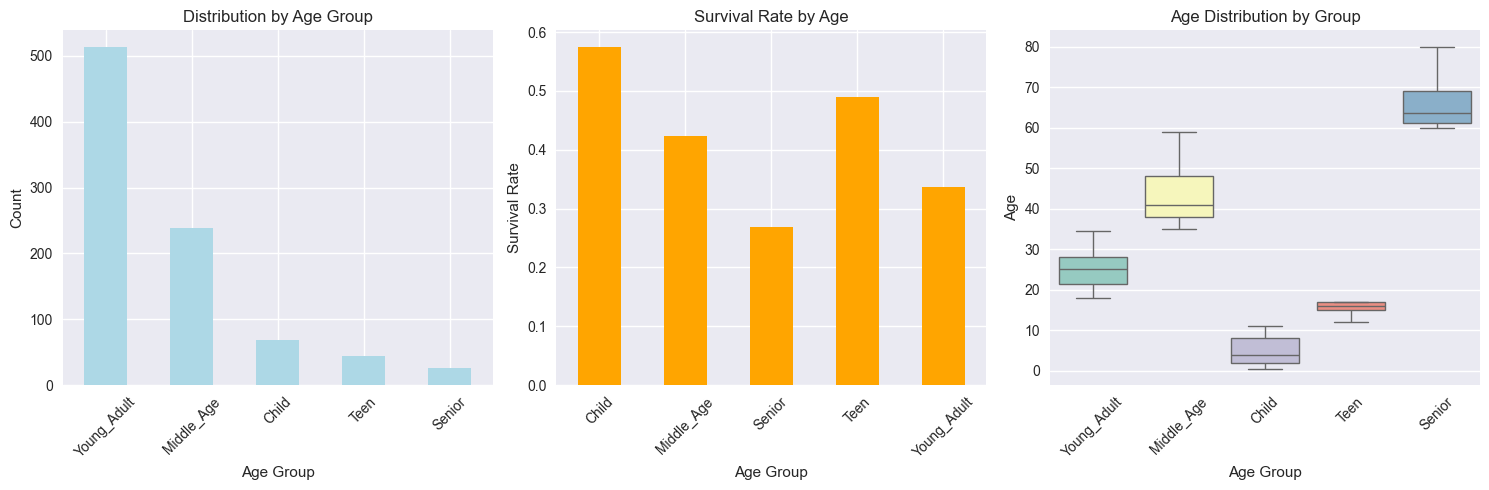

In [7]:
print("\n👶👨👴 FEATURE 3: AGE GROUPS")
print("=" * 25)


# Create age bins based on historical demographic analysis
def categorize_age(age):
    if age < 12:
        return "Child"
    elif age < 18:
        return "Teen"
    elif age < 35:
        return "Young_Adult"
    elif age < 60:
        return "Middle_Age"
    else:
        return "Senior"


df_features["AgeGroup"] = df_features["Age"].apply(categorize_age)

# Analysis by age group
age_group_analysis = (
    df_features.groupby("AgeGroup")["Survived"].agg(["count", "sum", "mean"]).round(3)
)
age_group_analysis.columns = ["Total", "Survivors", "Survival_Rate"]
print("Survival by age group:")
print(age_group_analysis)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_features["AgeGroup"].value_counts().plot(kind="bar", color="lightblue")
plt.title("Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
age_group_analysis["Survival_Rate"].plot(kind="bar", color="orange")
plt.title("Survival Rate by Age")
plt.xlabel("Age Group")
plt.ylabel("Survival Rate")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=df_features, x="AgeGroup", y="Age", palette="Set3")
plt.title("Age Distribution by Group")
plt.xlabel("Age Group")
plt.xticks(rotation=45)

plt.tight_layout()
save_current_plot("age_groups_analysis", "../results/figures/feature_engineering/")
plt.show()

### 3.4 Fare Bins


💰 FEATURE 4: FARE BINS
Survival by fare category:
         Total  Survivors  Survival_Rate
FareBin                                 
Low        223         44          0.197
Medium     224         68          0.304
High       222        101          0.455
Premium    222        129          0.581

Fare ranges by category:
           min     max
FareBin               
Low       0.00    7.90
Medium    7.92   14.45
High     14.46   31.00
Premium  31.28  512.33
✅ Graph saved: ../results/figures/feature_engineering/fare_bins_analysis.png


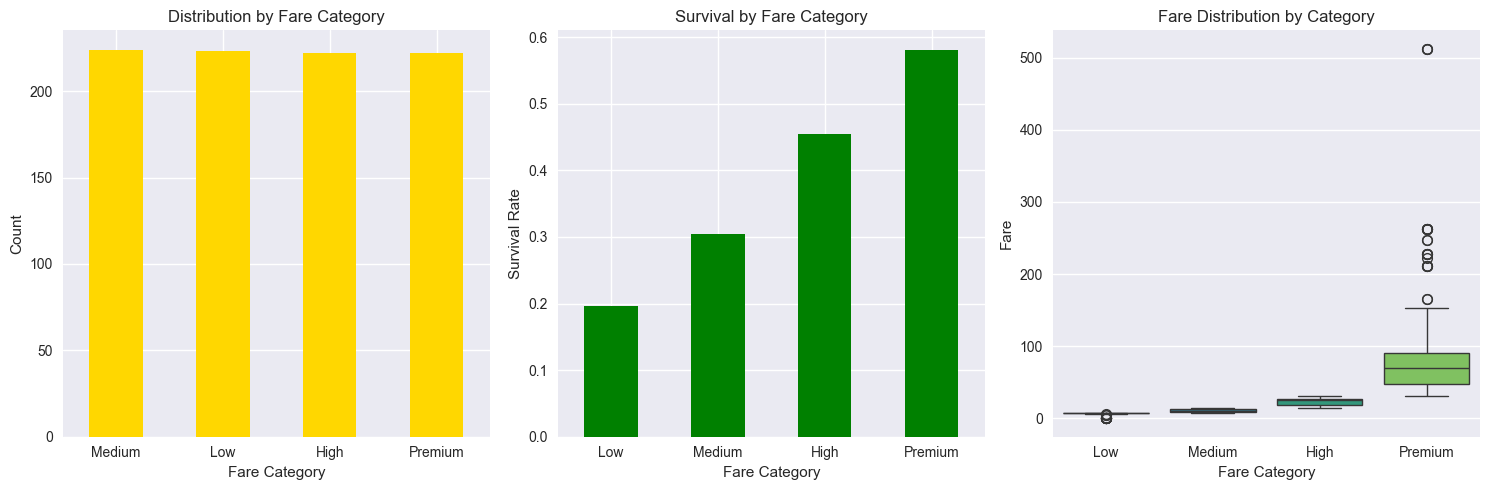

In [8]:
print("\n💰 FEATURE 4: FARE BINS")
print("=" * 20)

# Create fare quartiles
df_features["FareBin"] = pd.qcut(
    df_features["Fare"], q=4, labels=["Low", "Medium", "High", "Premium"]
)

# Analysis by fare category
fare_bin_analysis = (
    df_features.groupby("FareBin")["Survived"].agg(["count", "sum", "mean"]).round(3)
)
fare_bin_analysis.columns = ["Total", "Survivors", "Survival_Rate"]
print("Survival by fare category:")
print(fare_bin_analysis)

# Show ranges for each bin
fare_ranges = df_features.groupby("FareBin")["Fare"].agg(["min", "max"]).round(2)
print("\nFare ranges by category:")
print(fare_ranges)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_features["FareBin"].value_counts().plot(kind="bar", color="gold")
plt.title("Distribution by Fare Category")
plt.xlabel("Fare Category")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
fare_bin_analysis["Survival_Rate"].plot(kind="bar", color="green")
plt.title("Survival by Fare Category")
plt.xlabel("Fare Category")
plt.ylabel("Survival Rate")
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
sns.boxplot(data=df_features, x="FareBin", y="Fare", palette="viridis")
plt.title("Fare Distribution by Category")
plt.xlabel("Fare Category")

plt.tight_layout()
save_current_plot("fare_bins_analysis", "../results/figures/feature_engineering/")
plt.show()

### 3.5 Titles Extracted from Names (using original data)


🎩 FEATURE 5: TITLES FROM NAMES
Title distribution:
Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

Survival by title:
                  Total  Survivors  Survival_Rate
Title_Simplified                                 
Master               40         23          0.575
Miss                184        129          0.701
Mr                  517         81          0.157
Mrs                 126        100          0.794
Officer              18          5          0.278
Rare                  1          1          1.000
Royalty               5          3          0.600
✅ Graph saved: ../results/figures/feature_engineering/titles_analysis.png


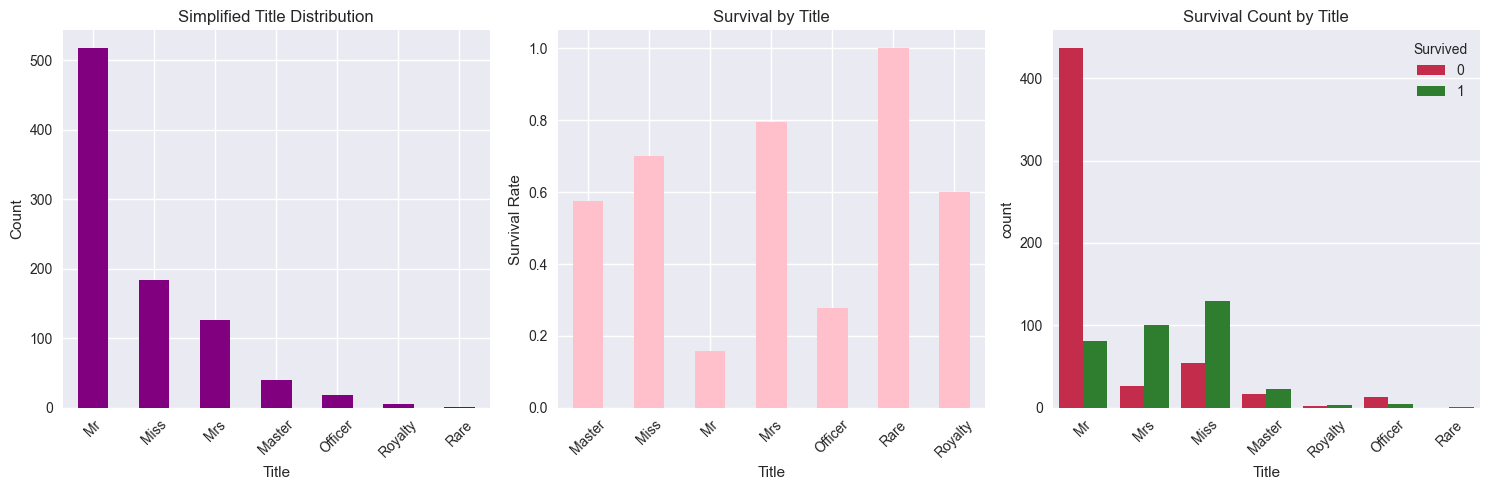

In [9]:
print("\n🎩 FEATURE 5: TITLES FROM NAMES")
print("=" * 30)

# We need to load the original names
df_original = pd.read_csv("../data/raw/titanic.csv")


# Extract titles using regular expressions
def extract_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    if title_search:
        return title_search.group(1)
    return ""


df_features["Title"] = df_original["Name"].apply(extract_title)

# Analyze title distribution
title_counts = df_features["Title"].value_counts()
print("Title distribution:")
print(title_counts)


# Simplify rare titles into categories
def simplify_title(title):
    if title in ["Mr"]:
        return "Mr"
    elif title in ["Miss", "Mlle"]:
        return "Miss"
    elif title in ["Mrs", "Mme"]:
        return "Mrs"
    elif title in ["Master"]:
        return "Master"
    elif title in ["Dr", "Rev", "Col", "Major", "Capt"]:
        return "Officer"
    elif title in ["Countess", "Lady", "Sir", "Don", "Dona", "Jonkheer"]:
        return "Royalty"
    else:
        return "Rare"


df_features["Title_Simplified"] = df_features["Title"].apply(simplify_title)

# Analysis by title
title_analysis = (
    df_features.groupby("Title_Simplified")["Survived"]
    .agg(["count", "sum", "mean"])
    .round(3)
)
title_analysis.columns = ["Total", "Survivors", "Survival_Rate"]
print("\nSurvival by title:")
print(title_analysis)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_features["Title_Simplified"].value_counts().plot(kind="bar", color="purple")
plt.title("Simplified Title Distribution")
plt.xlabel("Title")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
title_analysis["Survival_Rate"].plot(kind="bar", color="pink")
plt.title("Survival by Title")
plt.xlabel("Title")
plt.ylabel("Survival Rate")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.countplot(
    data=df_features,
    x="Title_Simplified",
    hue="Survived",
    palette=["crimson", "forestgreen"],
)
plt.title("Survival Count by Title")
plt.xlabel("Title")
plt.xticks(rotation=45)

plt.tight_layout()

save_current_plot("titles_analysis", "../results/figures/feature_engineering/")
plt.show()

### 3.6 Interaction Variables


🔗 FEATURE 6: INTERACTION VARIABLES
Survival by Sex_Pclass:
               count   mean
Sex_Pclass                 
female_Class1     94  0.968
female_Class2     76  0.921
female_Class3    144  0.500
male_Class1      122  0.369
male_Class2      108  0.157
male_Class3      347  0.135

Survival by Age_Sex:
              count   mean
Age_Sex                   
Adult_Female    259  0.753
Adult_Male      519  0.166
Young           113  0.540
✅ Graph saved: ../results/figures/feature_engineering/interaction_variables.png


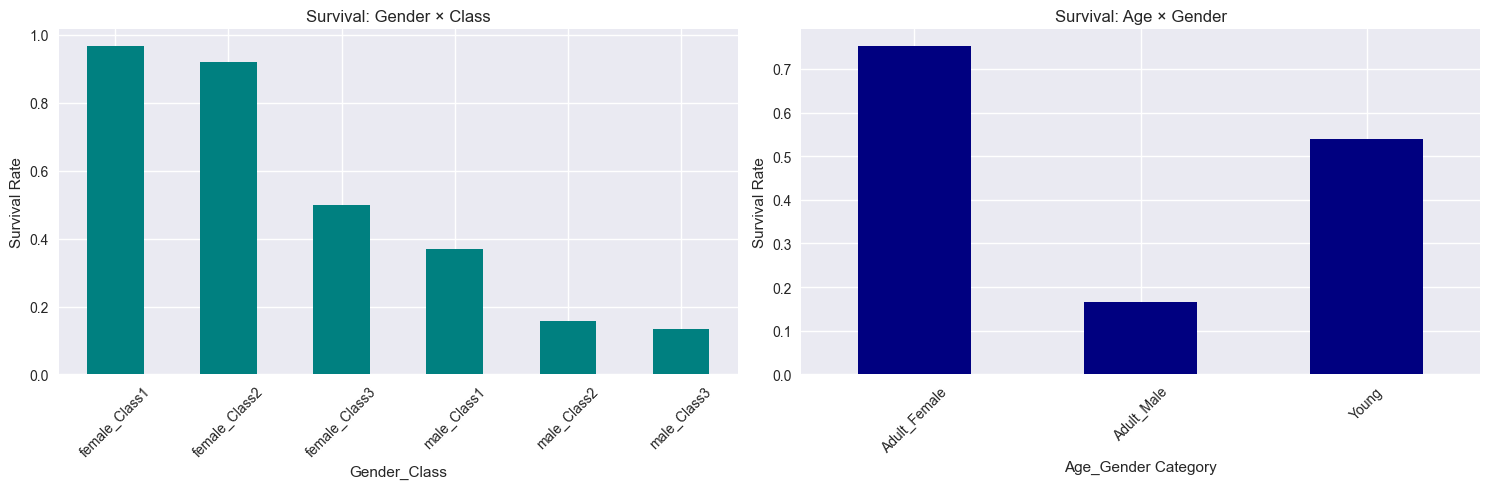

In [10]:
print("\n🔗 FEATURE 6: INTERACTION VARIABLES")
print("=" * 35)

# Create important interaction variables based on EDA
# Sex_Pclass: The most predictive combination according to EDA
df_features["Sex_Pclass"] = (
    df_features["Sex"] + "_Class" + df_features["Pclass"].astype(str)
)


# Age_Sex: Age-gender interaction
def age_sex_category(row):
    if row["AgeGroup"] in ["Child", "Teen"]:
        return "Young"
    elif row["Sex"] == "female":
        return "Adult_Female"
    else:
        return "Adult_Male"


df_features["Age_Sex"] = df_features.apply(age_sex_category, axis=1)

# Interaction variables analysis
print("Survival by Sex_Pclass:")
sex_pclass_analysis = (
    df_features.groupby("Sex_Pclass")["Survived"].agg(["count", "mean"]).round(3)
)
print(sex_pclass_analysis)

print("\nSurvival by Age_Sex:")
age_sex_analysis = (
    df_features.groupby("Age_Sex")["Survived"].agg(["count", "mean"]).round(3)
)
print(age_sex_analysis)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sex_pclass_analysis["mean"].plot(kind="bar", color="teal")
plt.title("Survival: Gender × Class")
plt.xlabel("Gender_Class")
plt.ylabel("Survival Rate")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
age_sex_analysis["mean"].plot(kind="bar", color="navy")
plt.title("Survival: Age × Gender")
plt.xlabel("Age_Gender Category")
plt.ylabel("Survival Rate")
plt.xticks(rotation=45)

plt.tight_layout()
save_current_plot("interaction_variables", "../results/figures/feature_engineering/")
plt.show()

## 4. Encoding Categorical Variables

In [11]:
print("\n🔢 ENCODING CATEGORICAL VARIABLES")
print("=" * 40)

# Create copy for encoding
df_encoded = df_features.copy()


🔢 ENCODING CATEGORICAL VARIABLES


### 4.1 Label Encoding for Binary Variables

In [12]:
print("\n📊 LABEL ENCODING (Binary Variables):")

# Sex: male=0, female=1
le_sex = LabelEncoder()
df_encoded["Sex_Encoded"] = le_sex.fit_transform(df_encoded["Sex"])
print(f"Sex: {dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))}")

# Embarked: ordinal by frequency
le_embarked = LabelEncoder()
df_encoded["Embarked_Encoded"] = le_embarked.fit_transform(df_encoded["Embarked"])
print(
    f"Embarked: {dict(zip(le_embarked.classes_, le_embarked.transform(le_embarked.classes_)))}"
)


📊 LABEL ENCODING (Binary Variables):
Sex: {'female': np.int64(0), 'male': np.int64(1)}
Embarked: {'C': np.int64(0), 'Q': np.int64(1), 'S': np.int64(2)}


### 4.2 Ordinal Encoding for Ordered Variables

In [13]:
print("\n📈 ORDINAL ENCODING (Ordered Variables):")

# AgeGroup: natural order
age_order = ["Child", "Teen", "Young_Adult", "Middle_Age", "Senior"]
oe_age = OrdinalEncoder(categories=[age_order])
df_encoded["AgeGroup_Encoded"] = oe_age.fit_transform(df_encoded[["AgeGroup"]]).astype(
    int
)
print(f"AgeGroup: {dict(zip(age_order, range(len(age_order))))}")

# FareBin: natural order
fare_order = ["Low", "Medium", "High", "Premium"]
oe_fare = OrdinalEncoder(categories=[fare_order])
df_encoded["FareBin_Encoded"] = oe_fare.fit_transform(df_encoded[["FareBin"]]).astype(
    int
)
print(f"FareBin: {dict(zip(fare_order, range(len(fare_order))))}")


📈 ORDINAL ENCODING (Ordered Variables):
AgeGroup: {'Child': 0, 'Teen': 1, 'Young_Adult': 2, 'Middle_Age': 3, 'Senior': 4}
FareBin: {'Low': 0, 'Medium': 1, 'High': 2, 'Premium': 3}


### 4.3 One-Hot Encoding for Nominal Variables

In [14]:
print("\n🔥 ONE-HOT ENCODING (Nominal Variables):")

# Title_Simplified
title_dummies = pd.get_dummies(df_encoded["Title_Simplified"], prefix="Title")
df_encoded = pd.concat([df_encoded, title_dummies], axis=1)
print(f"Title_Simplified → {title_dummies.columns.tolist()}")

# Sex_Pclass (important interaction)
sex_pclass_dummies = pd.get_dummies(df_encoded["Sex_Pclass"], prefix="SexPclass")
df_encoded = pd.concat([df_encoded, sex_pclass_dummies], axis=1)
print(f"Sex_Pclass → {sex_pclass_dummies.columns.tolist()}")

# Age_Sex
age_sex_dummies = pd.get_dummies(df_encoded["Age_Sex"], prefix="AgeSex")
df_encoded = pd.concat([df_encoded, age_sex_dummies], axis=1)
print(f"Age_Sex → {age_sex_dummies.columns.tolist()}")


🔥 ONE-HOT ENCODING (Nominal Variables):
Title_Simplified → ['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Rare', 'Title_Royalty']
Sex_Pclass → ['SexPclass_female_Class1', 'SexPclass_female_Class2', 'SexPclass_female_Class3', 'SexPclass_male_Class1', 'SexPclass_male_Class2', 'SexPclass_male_Class3']
Age_Sex → ['AgeSex_Adult_Female', 'AgeSex_Adult_Male', 'AgeSex_Young']


## 5. Final Feature Selection

In [15]:
print("\n🎯 FINAL FEATURE SELECTION")
print("=" * 35)

# Relevant original variables
original_features = [
    "Survived",
    "Pclass",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Cabin_Known",
]

# New numeric features
new_numeric_features = ["FamilySize", "IsAlone"]

# Encoded features
encoded_features = [
    "Sex_Encoded",
    "Embarked_Encoded",
    "AgeGroup_Encoded",
    "FareBin_Encoded",
]

# One-hot encoded features
onehot_features = (
    title_dummies.columns.tolist()
    + sex_pclass_dummies.columns.tolist()
    + age_sex_dummies.columns.tolist()
)

# Create final dataset
final_features = (
    original_features + new_numeric_features + encoded_features + onehot_features
)

df_final = df_encoded[final_features].copy()

print(f"📊 Final features: {len(final_features)}")
print(f"📈 Final dimensions: {df_final.shape}")

print("\nFeature categories:")
print(f"  - Original: {len(original_features)}")
print(f"  - New numeric: {len(new_numeric_features)}")
print(f"  - Encoded: {len(encoded_features)}")
print(f"  - One-hot: {len(onehot_features)}")


🎯 FINAL FEATURE SELECTION
📊 Final features: 29
📈 Final dimensions: (891, 29)

Feature categories:
  - Original: 7
  - New numeric: 2
  - Encoded: 4
  - One-hot: 16


## 6. Scaling Numerical Variables

In [16]:
print("\n📏 SCALING NUMERICAL VARIABLES")
print("=" * 35)

# Identify numerical variables for scaling (excluding target and dummies)
numeric_features_to_scale = [
    "Pclass",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "FamilySize",
    "Sex_Encoded",
    "Embarked_Encoded",
    "AgeGroup_Encoded",
    "FareBin_Encoded",
]

# Apply StandardScaler
scaler = StandardScaler()
df_scaled = df_final.copy()

# Scale only numerical features (not dummies or target)
df_scaled[numeric_features_to_scale] = scaler.fit_transform(
    df_final[numeric_features_to_scale]
)

print("✅ Variables scaled with StandardScaler:")
print(f"  - {len(numeric_features_to_scale)} numerical variables")
print(f"  - Mean ≈ 0, Standard deviation ≈ 1")

# Verify scaling
print("\nScaling verification (first 5 variables):")
scaling_check = df_scaled[numeric_features_to_scale[:5]].describe()
print(scaling_check.round(3))


📏 SCALING NUMERICAL VARIABLES
✅ Variables scaled with StandardScaler:
  - 10 numerical variables
  - Mean ≈ 0, Standard deviation ≈ 1

Scaling verification (first 5 variables):
        Pclass      Age    SibSp    Parch     Fare
count  891.000  891.000  891.000  891.000  891.000
mean    -0.000    0.000    0.000    0.000    0.000
std      1.001    1.001    1.001    1.001    1.001
min     -1.566   -2.158   -0.475   -0.474   -0.648
25%     -0.369   -0.572   -0.475   -0.474   -0.489
50%      0.827   -0.234   -0.475   -0.474   -0.357
75%      0.827    0.518    0.433   -0.474   -0.024
max      0.827    3.827    6.784    6.974    9.667


## 7. Final Correlation Analysis


🔗 FINAL CORRELATION ANALYSIS
Top 10 correlations with Survived:
Survived                   1.000
AgeSex_Adult_Female        0.486
SexPclass_female_Class1    0.413
Title_Mrs                  0.342
SexPclass_female_Class2    0.337
Title_Miss                 0.333
Cabin_Known                0.317
FareBin_Encoded            0.299
Fare                       0.257
AgeSex_Young               0.122
Name: Survived, dtype: float64

Bottom 5 correlations with Survived:
Pclass                  -0.338
SexPclass_male_Class3   -0.408
AgeSex_Adult_Male       -0.530
Sex_Encoded             -0.543
Title_Mr                -0.549
Name: Survived, dtype: float64
✅ Graph saved: ../results/figures/feature_engineering/final_correlations.png


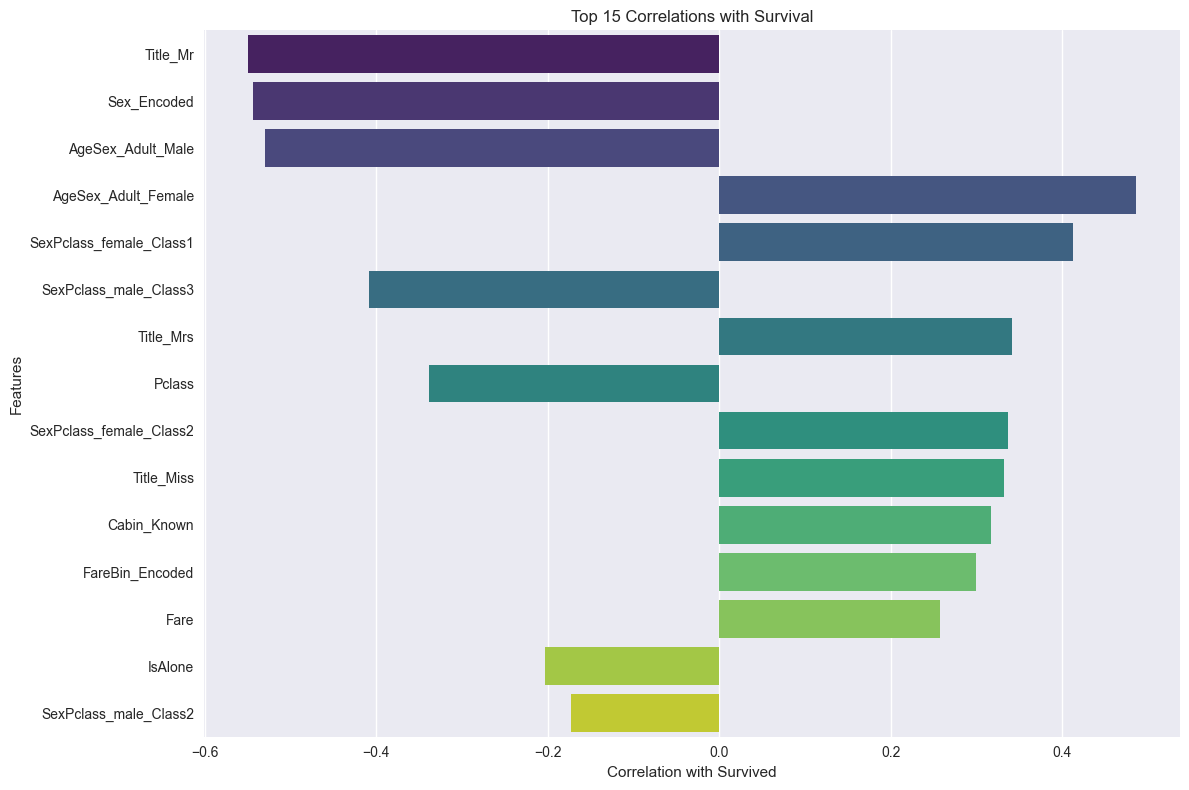

In [17]:
print("\n🔗 FINAL CORRELATION ANALYSIS")
print("=" * 35)

# Correlation matrix with target
correlation_with_target = df_scaled.corr()["Survived"].sort_values(ascending=False)
print("Top 10 correlations with Survived:")
print(correlation_with_target.head(10).round(3))

print("\nBottom 5 correlations with Survived:")
print(correlation_with_target.tail(5).round(3))

# Visualization of important correlations
plt.figure(figsize=(12, 8))

# Top correlations (absolute)
top_correlations = (
    correlation_with_target.drop("Survived").abs().sort_values(ascending=False).head(15)
)
top_corr_values = correlation_with_target[top_correlations.index]

sns.barplot(x=top_corr_values.values, y=top_corr_values.index, palette="viridis")
plt.title("Top 15 Correlations with Survival")
plt.xlabel("Correlation with Survived")
plt.ylabel("Features")

plt.tight_layout()
save_current_plot("final_correlations", "../results/figures/feature_engineering/")
plt.show()

## 8. Feature Engineering Summary

In [18]:
print("\n📝 FEATURE ENGINEERING SUMMARY")
print("=" * 40)

feature_summary = {
    "Original dataset": f"{df.shape[0]} rows × {df.shape[1]} columns",
    "Final dataset": f"{df_final.shape[0]} rows × {df_final.shape[1]} columns",
    "Features added": len(final_features) - len(original_features),
    "New variables created": [
        "FamilySize (SibSp + Parch + 1)",
        "IsAlone (FamilySize == 1)",
        "AgeGroup (5 categories)",
        "FareBin (4 quartiles)",
        "Title_Simplified (6 categories)",
        "Interaction variables (Sex_Pclass, Age_Sex)",
    ],
    "Encoding applied": [
        "Label Encoding: Sex, Embarked",
        "Ordinal Encoding: AgeGroup, FareBin",
        "One-Hot Encoding: Title, Sex_Pclass, Age_Sex",
    ],
    "Scaling": "StandardScaler on numerical variables",
    "Top 3 features": correlation_with_target.drop("Survived")
    .abs()
    .head(3)
    .index.tolist(),
}

for key, value in feature_summary.items():
    print(f"✅ {key}: {value}")


📝 FEATURE ENGINEERING SUMMARY
✅ Original dataset: 891 rows × 9 columns
✅ Final dataset: 891 rows × 29 columns
✅ Features added: 22
✅ New variables created: ['FamilySize (SibSp + Parch + 1)', 'IsAlone (FamilySize == 1)', 'AgeGroup (5 categories)', 'FareBin (4 quartiles)', 'Title_Simplified (6 categories)', 'Interaction variables (Sex_Pclass, Age_Sex)']
✅ Encoding applied: ['Label Encoding: Sex, Embarked', 'Ordinal Encoding: AgeGroup, FareBin', 'One-Hot Encoding: Title, Sex_Pclass, Age_Sex']
✅ Scaling: StandardScaler on numerical variables
✅ Top 3 features: ['AgeSex_Adult_Female', 'SexPclass_female_Class1', 'Title_Mrs']


## 9. Save Dataset with Features

In [19]:
print("\n💾 SAVING FEATURED DATASET")
print("=" * 35)

# Save unscaled dataset (for analysis)
output_path_features = "../data/processed/features_engineered.csv"
df_final.to_csv(output_path_features, index=False)
print(f"✅ Dataset with features saved: {output_path_features}")

# Save scaled dataset (for modeling)
output_path_scaled = "../data/processed/features_scaled.csv"
df_scaled.to_csv(output_path_scaled, index=False)
print(f"✅ Scaled dataset saved: {output_path_scaled}")

# Verification
df_verify_features = pd.read_csv(output_path_features)
df_verify_scaled = pd.read_csv(output_path_scaled)

print(f"🔍 Features verification: {df_verify_features.shape}")
print(f"🔍 Scaled verification: {df_verify_scaled.shape}")


💾 SAVING FEATURED DATASET
✅ Dataset with features saved: ../data/processed/features_engineered.csv
✅ Scaled dataset saved: ../data/processed/features_scaled.csv
🔍 Features verification: (891, 29)
🔍 Scaled verification: (891, 29)


## 10. Next Steps

In [20]:
print("\n🚀 NEXT STEPS")
print("=" * 18)

next_steps = [
    "Modeling (04_modeling.ipynb)",
    "- Stratified train/validation/test split",
    "- Implement base algorithms:",
    "  * Logistic Regression",
    "  * Random Forest",
    "  * Support Vector Machine",
    "  * Naive Bayes",
    "- Cross-validation for robustness",
    "- Hyperparameter tuning",
    "Evaluation (05_model_evaluation.ipynb)",
    "- Performance metrics",
    "- Feature importance analysis",
    "- Results interpretation",
    "- Model comparison",
]

for i, step in enumerate(next_steps, 1):
    if step.startswith("-") or step.startswith(" "):
        print(f"  {step}")
    else:
        print(f"{i}. {step}")

print("\n✅ Feature engineering completed successfully!")
print("📊 Datasets ready for modeling")
print(f"🎯 {len(final_features)} features available for training")


🚀 NEXT STEPS
1. Modeling (04_modeling.ipynb)
  - Stratified train/validation/test split
  - Implement base algorithms:
    * Logistic Regression
    * Random Forest
    * Support Vector Machine
    * Naive Bayes
  - Cross-validation for robustness
  - Hyperparameter tuning
10. Evaluation (05_model_evaluation.ipynb)
  - Performance metrics
  - Feature importance analysis
  - Results interpretation
  - Model comparison

✅ Feature engineering completed successfully!
📊 Datasets ready for modeling
🎯 29 features available for training
